# Merfish to merfish registration with tools

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import nrrd
import time

import tools

import imp
imp.reload(tools)

/nafs/dtward/torch_venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  app.launch_new_instance()


<module 'tools' from '/ifshome/oamiuwu/STalign/tools.py'>

# Load atlas image

<IPython.core.display.Javascript object>


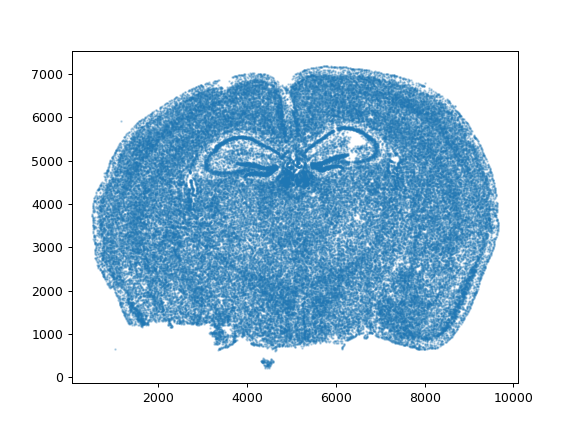

<IPython.core.display.Javascript object>


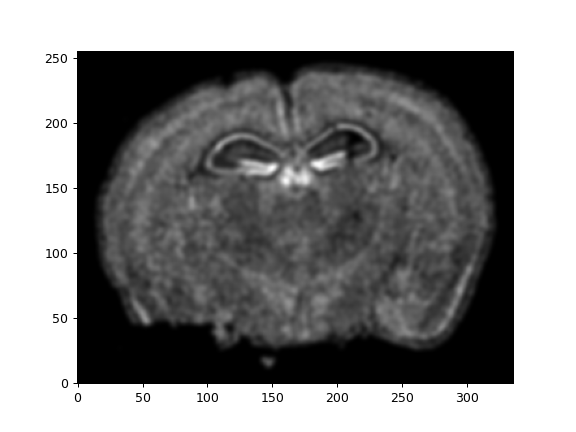

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


In [2]:
files = glob.glob('/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/*metadata*.csv.gz')
files.sort()
fname = files[5]

df = pd.read_csv(fname)
xI = np.array(df['center_x'])
yI = np.array(df['center_y'])

fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.25)

XI,YI,I,fig = tools.rasterize(xI,yI)
ax = fig.axes[0]

# Load target image

<IPython.core.display.Javascript object>


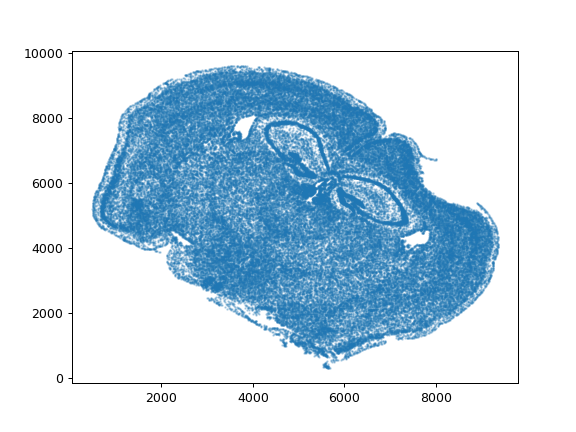

<IPython.core.display.Javascript object>


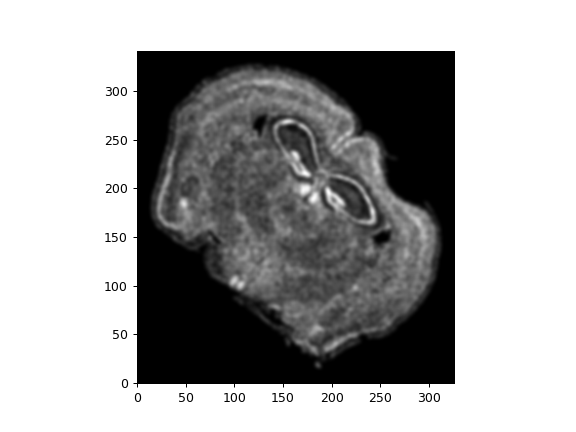

0 of 84172
10000 of 84172
20000 of 84172
30000 of 84172
40000 of 84172
50000 of 84172
60000 of 84172
70000 of 84172
80000 of 84172
84171 of 84172


In [3]:
fname = files[4]

df = pd.read_csv(fname)
xJ = np.array(df['center_x'])
yJ = np.array(df['center_y'])

fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=0.25)

XJ,YJ,J,fig = tools.rasterize(xJ,yJ)
ax = fig.axes[0]

# Declare landmark points and plot them

In [4]:
pointsI = np.array([[231,146],[233,173],[166,166],[167,101],[182,227],[36,175],
                       [126,104],[141,231],[112,55],[121,282],[164,132],[169,201],[78,172]])*30.
pointsJ = np.array([[250,240],[268,222],[210,179],[165,242],[264,144],[100,102],
                       [130,214],[221,115],[93,247],[245,62],[180,208],[230,158],[135,132]])*30.

In [5]:
I = tools.normalize(I)
YI = np.array(range(I.shape[1]))*30.
XI = np.array(range(I.shape[2]))*30.

J = tools.normalize(J)
YJ = np.array(range(J.shape[1]))*30.
XJ = np.array(range(J.shape[2]))*30.

extentI = tools.extent_from_x((YI,XI))
extentJ = tools.extent_from_x((YJ,XJ))

<IPython.core.display.Javascript object>


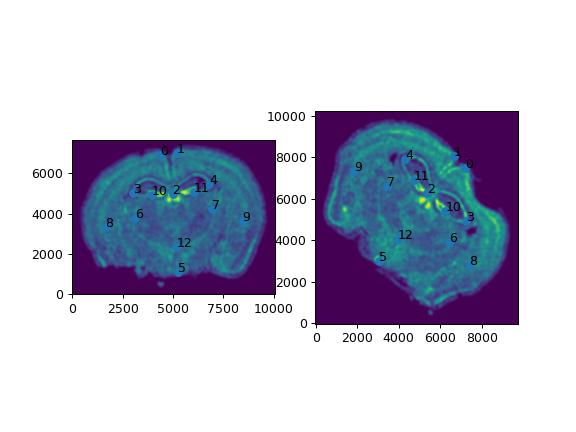

In [6]:
fig,ax = plt.subplots(1,2)
ax[0].imshow((I/I.max()).transpose(1,2,0), extent=extentI)
ax[1].imshow((J).transpose(1,2,0), extent=extentJ)

ax[0].scatter(pointsI[:,1],pointsI[:,0])
ax[1].scatter(pointsJ[:,1],pointsJ[:,0])
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}')

# Run the mapping code

/nafs/dtward/torch_venv/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


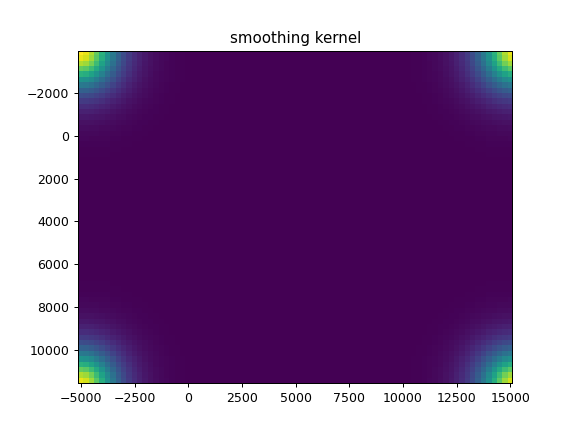

<IPython.core.display.Javascript object>


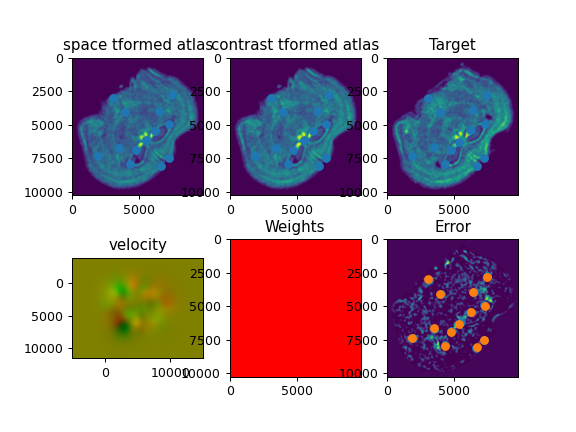

<IPython.core.display.Javascript object>


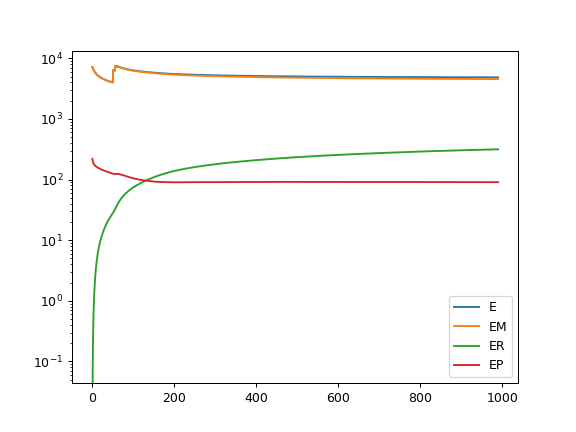

In [7]:
imp.reload(tools)
L,T = tools.L_T_from_points(pointsI,pointsJ)
device = 'cpu'
params = {'L':L,'T':T,
          'niter':1000,
          'pointsI':pointsI,
          'pointsJ':pointsJ,
          'device':device,
          'sigmaM':0.2
          }

A,v,xv = tools.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

# Apply transform to atlas image

<IPython.core.display.Javascript object>


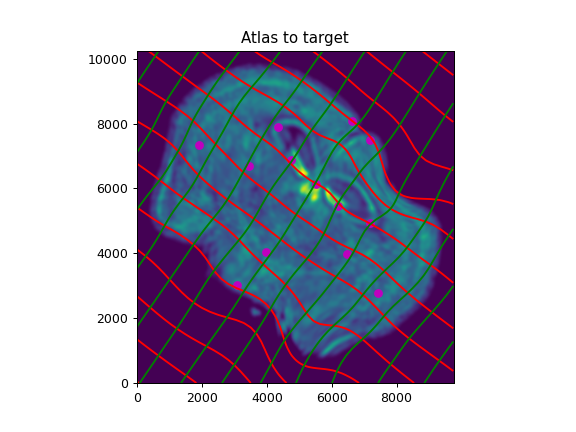

/ifshome/oamiuwu/STalign/tools.py:1005: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
/ifshome/oamiuwu/STalign/tools.py:1006: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v)
/ifshome/oamiuwu/STalign/tools.py:1018: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


In [8]:
levels = np.arange(-100000,100000,1000)

fig,ax = plt.subplots()
phii = tools.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = tools.transform_image_atlas_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
phipointsI = tools.transform_points_atlas_to_target(xv,v,A,pointsI)

ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('Atlas to target')

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.scatter(phipointsI[:,1].detach(),phipointsI[:,0].detach(),c="m")

# Apply transform to target image

<IPython.core.display.Javascript object>


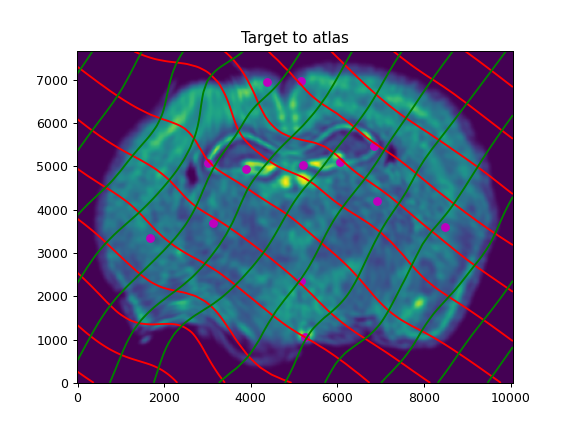

In [9]:
levels = np.arange(-100000,100000,1000)

fig,ax = plt.subplots()
phi = tools.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = tools.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],J,[YI,XI])
phiipointsJ = tools.transform_points_target_to_atlas(xv,v,A,pointsJ)

ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('Target to atlas')

ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="m")